In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate
%matplotlib inline

## Migrated / In-situ

The biggest / easiest improvement in the analytic model would be in how the migrated / in-situ ratio is handled.
I am assuming that the migrated /  in-situ (eq. 11) refered to stellar number or mass (I wasn't clear on this on this and I think the text should be changed to make the meaning more explicit). I also am assuming that the ratio is that of the *current* in-situ component (stars born in the solar zone and STILL there) as oppossed to *all* stars born in the solar zone.

Currently, the model accounts for a crude dependence on distance from the solar annulus (in the form of $Fr$) and
age dependence. Below, I will modify the distance dependence and add two important components : 

- Total mass born at a given formation radius
    + The disk has a scale length ~ 2.5 kpc, so many more stars born in interior of disk than at solar zone. I assume the scale length hasn't changed with time.
- Relative age abundance
    + Given SFHs of each zone, the relative number of stars with a given formation radius is also a function of formation time.
    

In detail, most of the calculations below should be done as integrals in radius across each zone. For simplicity, I assume the relevant properties are flat across each zone 

### Properties of Disk

Assume disk has a exponential scale length of 2.5 kpc and solar properties below.

In [2]:
def surface_density(R, hr=2.5):
    return np.exp(-R/hr)

solR = 8.0  # kpc
solV = 220.0 # km/s

###  Total Mass in each zone

$Mr$ : Mass at some radius R

In [3]:
def mass_at_R(R, hr=2.5):
    area = np.pi * ((R+1.0)**2 - (R-1.0)**2)
    return surface_density(R, hr=hr) * area

def area_at_R(R):
    return np.pi * ((R+1.0)**2 - (R-1.0)**2)



### Gaussian falloff for probability of migrating to solar annulus

Currently, $Fr$ is linearly porportional to distance. Change to gaussian because fall off should be stronger than linear and gaussian will produce a better match to simulations (see below).

Tests above show sigma~ 2kpc gives the best match to simulations. 
So P(migrate) is 4.5 times greater for Rform = 6 kpc than  4 kpc.


In [4]:
def Fr(rform, rfin=8.0, sigma=2.0):
    mig_normal = stats.norm(loc=rfin, scale=sigma)  # scale = 2.0 kpc
    return mig_normal.pdf(rform)

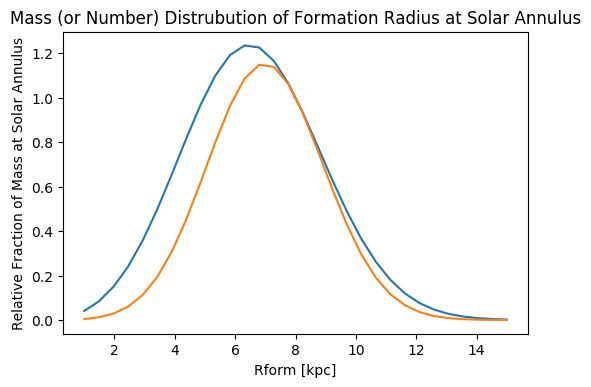

In [5]:
# Test of mass distribution * Fr 
radii = np.linspace(1, 15, 30)
plt.plot(radii, mass_at_R(radii, hr=2.5) * Fr(radii, sigma=2.5) / (mass_at_R(solR, hr=2.5) * Fr(solR, sigma=2.5)))
plt.plot(radii, mass_at_R(radii, hr=2.5) * Fr(radii, sigma=2.0) / (mass_at_R(solR, hr=2.5) * Fr(solR, sigma=2.0)))
plt.xlabel('Rform [kpc]')
plt.ylabel('Relative Fraction of Mass at Solar Annulus')
plt.title('Mass (or Number) Distrubution of Formation Radius at Solar Annulus')

Peak is at ~7 kpc and distribution is skewed towards the inner Galaxy. On the right track (see the end for comparison to sims).

### Relative age abundance

We have accounted for decrease in migration probability due to distance and the mass profile of the disk.
Still need to account for different SFHs of zones and increased migration probability of old stars.

Simply normalize SFHs and take ratio with in-situ solar zone to determine relative abundance of stars with a given age and formation radius.

The normalized SFHs are probabilities of tform at a given formation radius $p(t_{form} | R_{form})$


In [6]:
def SFR(tform, tauSFH):
    return tform * np.exp(-tform / tauSFH) 

def normalized_SFR(tform, tauSFH, t0=0, t1=12):
    """
    Normalized such that SFH is now a probabality p(tau)
    """
    sfr = SFR(tform, tauSFH)
    return sfr / integrate.fixed_quad(SFR, t0, t1, args=(tauSFH,), n=100)[0]

In [7]:
# SFH properties for different zones
tauSFH = {4: 3.0, 6: 3.0, 8: 3.0, 10: 6.0, 12: 12.0}
t0 = {4: 0.0, 6: 0.0, 8: 0.0, 10: 0.0, 12: 0.0} # used for SFH 
t1 = {4: 12.0, 6: 10.0, 8: 10.0, 10: 10.0, 12: 10.0} # used for SFH

In [8]:
tform = np.arange(0, 12.05, 0.1)   # [Gyr] every 100 million years

tform_2_12 = tform[20:]
tform_0_10 = tform[:-20]  # 0 to 10 
# For clarity, also have have time arrays that represent time since t=0 
t_0_12 = tform
t_0_10 = tform[:-20]  # 0 to 10 
t_2_12 = tform[20:]  # 2 to 12  to account for different start times


time_arrays = {4:t_2_12, 6:t_0_10, 8:t_0_10, 10:t_0_10, 12:t_0_10}
tindex_shift = {4:0, 6:-20, 8:-20, 10:-20, 12:-20}  #  needed because every zone except for r=4 has SFH over tform=[2,12] but t=[0,10]

In [9]:
sol_SFH = normalized_SFR(time_arrays[8], tauSFH[8], t0=t0[8], t1=t1[8])

def relative_age_abundance(rf):
    """
    normalized SFR relative to solar zone value
    """
    rform = int(rf)
    return normalized_SFR(time_arrays[rform], tauSFH[rform], t0=t0[rform], t1=t1[rform]) / sol_SFH

def relative_age_abundance_at_time(rf, t):     ## NOT used 
    rform = int(rf)
    tindx = np.searchsorted(tform, t)   # closest time 
    print(tindx,tform[tindx + tindex_shift[rform]] )
    return (normalized_SFR(tform[tindx + tindex_shift[rform]], tauSFH[rform], t0=t0[rform], t1=t1[rform]) /
            normalized_SFR(tform[tindx + tindex_shift[8]], tauSFH[8], t0=t0[8], t1=t1[8]))
       

/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


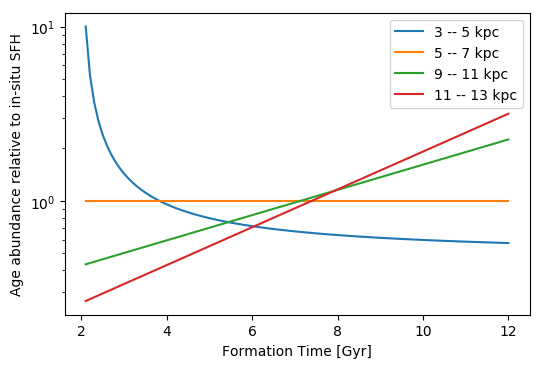

In [10]:
# Visual check on relative age abundance
plt.plot(t_2_12, relative_age_abundance(4), label='3 -- 5 kpc')
plt.plot(t_2_12, relative_age_abundance(6), label='5 -- 7 kpc')
plt.plot(t_2_12, relative_age_abundance(10), label='9 -- 11 kpc')
plt.plot(t_2_12, relative_age_abundance(12), label='11 -- 13 kpc')
plt.xlabel('Formation Time [Gyr]')
plt.ylabel('Age abundance relative to in-situ SFH')
plt.yscale('log')
plt.legend()

The above makes sense. The 3-5 kpc zone makes MANY more old stars than the solar zone, while the late time SFR of the outer disk outpaces the solar zone. I have ignored tform=0 -- 2 Gyr for the 3--5 kpc zone because the in-situ component is zero.

#### Age-dependence
Currently, the age dependence is linear. If we assume that migration is a diffusion process, the mean distance travelled in time $t$ is $\sim \sqrt(t)$. I include this below. Keeping this linear doesn't make a huge difference. However, this version seems to be better aligned with the fact that 1 Gyr stars have $\sigma_R \sim 20$ km/s and therefore can migrate signficantly. Let's call the age dependent migration coeffient $Ft$.



In [11]:
def Ft(tform):
    return (1.0 - tform/12.0)**0.5

### Putting it all together
let $R = R_{form}$ and
$t = t_{form}$ and $R_{solar} = 8$ kpc

$$
\frac{\mathrm{Migrated}}{\mathrm{in-situ}}\ |\ R, t = \frac{M_r(R)\ F_r(R)\ p(t|R)}{M_r(8) \ F_r(8) \ p(t|8)} \ F_t(t)
$$


where $Mr(R) / Mr(8) \times p(t|R) / p(t|8)$ is simply the relative mass or number of stars born at $R$ at time $t$.
$Fr$ describes the distance-dependence of migration into the solar zone (and is relative to the solar zone to be normalized). $Ft$ is the migration age-dependence and is *not* normalized because there is no radial dependence. 

In [12]:
def mig_insitu_ratio(tform, Rform, hr=2.5, sigma=2.0):
    """
    hr: scale length of disk (assumed 2.5 kpc)
    sigma: std of distance dependence gaussian
    
    As written, relative_age_abundance takes care of starting time difference for Rform = 4 kpc zone and
    normalization by solar zone.
    """
    Mr_times_Fr = mass_at_R(Rform, hr=hr) / mass_at_R(solR, hr=hr) * Fr(Rform, sigma=sigma) / Fr(solR, sigma=sigma)
    return Mr_times_Fr * relative_age_abundance(Rform) * Ft(tform)

/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


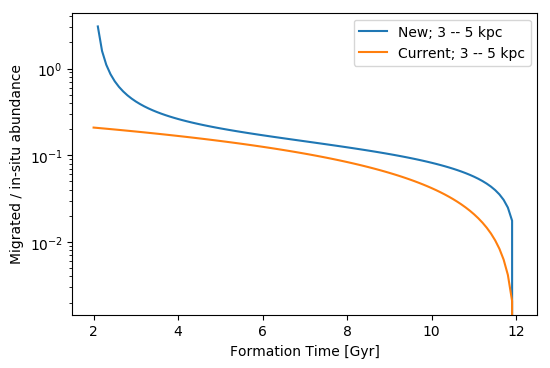

In [13]:
# Just Rform = 4 kpc as an example of old versus new

plt.plot(t_2_12, mig_insitu_ratio(tform_2_12, 4.0), label='New; 3 -- 5 kpc')
plt.plot(t_2_12, 0.25 * (1. - tform_2_12 / 12.0), label='Current; 3 -- 5 kpc')
plt.xlabel('Formation Time [Gyr]')
plt.ylabel('Migrated / in-situ abundance')
plt.yscale('log')
plt.legend()

The migrated to in-situ fraction for Rform ~ 4 kpc is higher than 1 at early times (even higher for tform = [0,2] Gyr) but quickly drops as the younger stars simply can't make it all the way to the solar annulus.

Notice the current methodology (0.25 * (1.0 - tform /12.0)) is signficantly lower at all tform and is still only 0.2 at tform=2 Gyr. For 10 Gyr old stars in the solar neighborhood, migrators should significantly outnumber the in-situ population.

/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


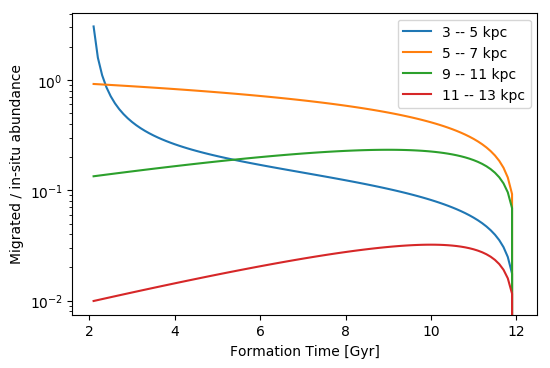

In [14]:
# Now all radial zones 
plt.plot(t_2_12, mig_insitu_ratio(tform_2_12, 4.0), label='3 -- 5 kpc')
plt.plot(t_2_12, mig_insitu_ratio(tform_2_12, 6.0), label='5 -- 7 kpc')
plt.plot(t_2_12, mig_insitu_ratio(tform_2_12, 10.0), label='9 -- 11 kpc')
plt.plot(t_2_12, mig_insitu_ratio(tform_2_12, 12.0), label='11 -- 13 kpc')
plt.xlabel('Formation Time [Gyr]')
plt.ylabel('Migrated / in-situ abundance')
plt.yscale('log')

plt.legend()

##### I suggest using something like the above for the migration/in-situ fraction

It rightfully shows that the inner Galaxy migrators always dominate over the outer Galaxy migrators due to the larger number of stars born there. It is also a better approximation of what we know from sims (see below).

### Rform distribution at Solar annulus and comparison to sims

We can now 'integrate' over formation time to get the formation radius distrubution at the solar zone. Because the distribution will be relative to the in-situ population, we can be crude with the integration and simply sum the Migrated/ in-situ fraction over time and compare it to the solar zone.

/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/Users/jquark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


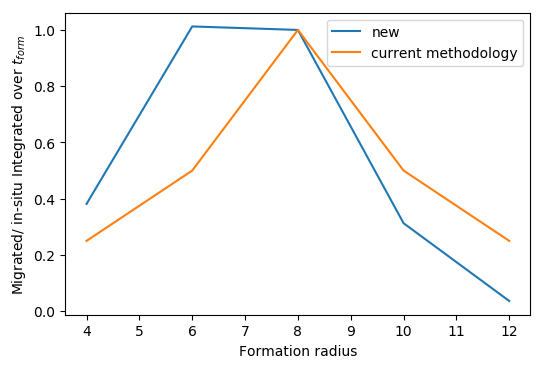

In [15]:
r_zones = np.arange(4.0, 12.1, 2.0) # all radial zones including a solar zone for comparison
total_solar_zone = np.sum(mig_insitu_ratio(tform_2_12, solR)[1:]) # sum of migrated/ in-situ for solar annulus
# This is just the summation of Ft over the input formation time array. Gives us a normalization (~dt)

plt.plot(r_zones, [np.sum(mig_insitu_ratio(tform_2_12, rr)[1:]) / total_solar_zone for rr in r_zones], label='new')
## line above just loops through each zone. the [1:] avoids tform = 2 Gyr, where the SFR of the solar zone is zero

# Now compare to current 
current_Fr = [0.25, 0.5, 1.0, 0.5, 0.25]  # 1.0 for solar zone
# will sum Mig/in-situ over formation time and make relative to solar zone as above
plt.plot(r_zones, [np.sum(curFr * (1.0 - tform_2_12/12.0)) / np.sum(1.0 - tform_2_12/12.0)
                   for curFr in current_Fr],
         label='current methodology')

plt.xlabel('Formation radius')
plt.ylabel('Migrated/ in-situ Integrated over $t_{form}$')
plt.legend()


 - The new methodology increases (decreases) the inner (outer) disk contribution relative to the current method.

 - The formation radius distribution now has a very broad peak and slightly favors the 5--7 kpc zone. 

 - These features are seen in simulations and follow from conservative assumptions regarding the SFHs and dynamics.

 - See the following for comparison to simulations.
    - Figure 15 of [Bird+ (2013)](http://iopscience.iop.org/article/10.1088/0004-637X/773/1/43/pdf)
    - Figure 3 of [Minchev+ (2013)](https://www.aanda.org/articles/aa/pdf/2013/10/aa20189-12.pdf)
    
 - See email for GCE consequences of this migration Rx

#### Misc Notes

 -   If anything the outer disk is still too pravelant relative to the sim results.